# Vector Autoregression Model

This notebook is **generalized code** to run a Vector Autoregression Model on the cleaned Zillow Home Value Index dataset created in a different notebook. Please reference `Vector Autoregression Model Exploration & Analysis` notebook for a more in depth look into Vector Autoregression and the associated data.

In [1]:
#location = "SaltLakeCityUT" #USER INPUT -- In Run_all

In [2]:
#forecast_horizon = 2 #USER INPUT -- In Run_all

In [3]:
#info_criterion = "BIC" #USER INPUT -- In Run_all

In [4]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style = "darkgrid")
import pickle

In [5]:
#Set up dataframe

market_area_city = location[:-2]
full_df = pd.read_pickle('fulldataframe.pkl')
full_df.set_index('date', inplace = True)
full_df.index.freq = 'm'
market_specific_features = [col for col in full_df.columns if market_area_city in col]
market_df = full_df[market_specific_features + ['MORTGAGE30US', 'MedianCPI', 'HomesForSale', 'HomesSold']].copy()

In [6]:
#Import Statsmodels Libraries

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic, bic
from statsmodels.tsa.stattools import adfuller

In [7]:
#Check for Stationarity with Augmented Dickey-Fuller Test  
p_values_n1 = np.array([])
n = 0

for column_name, column_data in market_df.iteritems():
    
    #first adf_test
    adf_test = adfuller(column_data, autolag = 'BIC')
    p_values_n1 = np.append(p_values_n1, adf_test[1])
    
#check p_values for first difference
if np.any(p_values_n1 > 0.05):
    df_differenced = market_df.diff().dropna()
    n = 1
    
p_values_n2 = np.array([])

for column_name, column_data in df_differenced.iteritems():
    
    #second adf_test
    adf_test = adfuller(column_data, autolag = 'BIC')
    p_values_n2 = np.append(p_values_n2, adf_test[1])

#check p_values for second difference
if np.any(p_values_n2 > 0.05) and (np.sum(p_values_n1 > 0.05) > np.sum(p_values_n2 > 0.05)):
    df_differenced = df_differenced.diff().dropna()
    n = 2  

In [8]:
#Split the data into Train and Test

test_obs = 12 
train_df = df_differenced[:-test_obs]
test_df = df_differenced[-test_obs:]

In [9]:
#Select the order p by minimizing BIC

model = VAR(train_df)
lag_order = model.select_order(maxlags = 12)

info_criterion = info_criterion.lower()

if info_criterion == "bic":
    p = lag_order.bic
elif info_criterion == "aic":
    p = lag_order.aic 
elif info_criterion == "hqic":
    p = lag_order.hqic
else:
    p = lag_order.fpe

In [10]:
#Fit the model on order p

result = model.fit(p)

In [11]:
#Use the last lagged values of order p from train_df to forecast the next test_obs time steps

lagged_values = train_df.values[-p:]

pred = result.forecast(y = lagged_values, steps = test_obs)
pred_lower = result.forecast_interval(y = lagged_values, steps = test_obs)[1]
pred_upper = result.forecast_interval(y = lagged_values, steps = test_obs)[2]

df_forecast = pd.DataFrame(data = pred, index = test_df.index[:test_obs], columns = test_df.columns)
df_forecast_lower = pd.DataFrame(data = pred_lower, index = test_df.index[:test_obs], columns = test_df.columns)
df_forecast_upper = pd.DataFrame(data = pred_upper, index = test_df.index[:test_obs], columns = test_df.columns)

In [12]:
#Invert differenced values

if n == 2:
    #if second differenced
    df_forecast = (market_df.iloc[-test_obs-1] - market_df.iloc[-test_obs-2]) + df_forecast.cumsum()
    df_forecast_lower = (market_df.iloc[-test_obs-1] - market_df.iloc[-test_obs-2]) + df_forecast_lower.cumsum()
    df_forecast_upper = (market_df.iloc[-test_obs-1] - market_df.iloc[-test_obs-2]) + df_forecast_upper.cumsum()
    
if n >= 1: 
    #if first differenced 
    df_forecast = market_df.iloc[-test_obs-1] + df_forecast.cumsum()
    df_forecast_lower = market_df.iloc[-test_obs-1] + df_forecast_lower.cumsum()
    df_forecast_upper = market_df.iloc[-test_obs-1] + df_forecast_upper.cumsum()

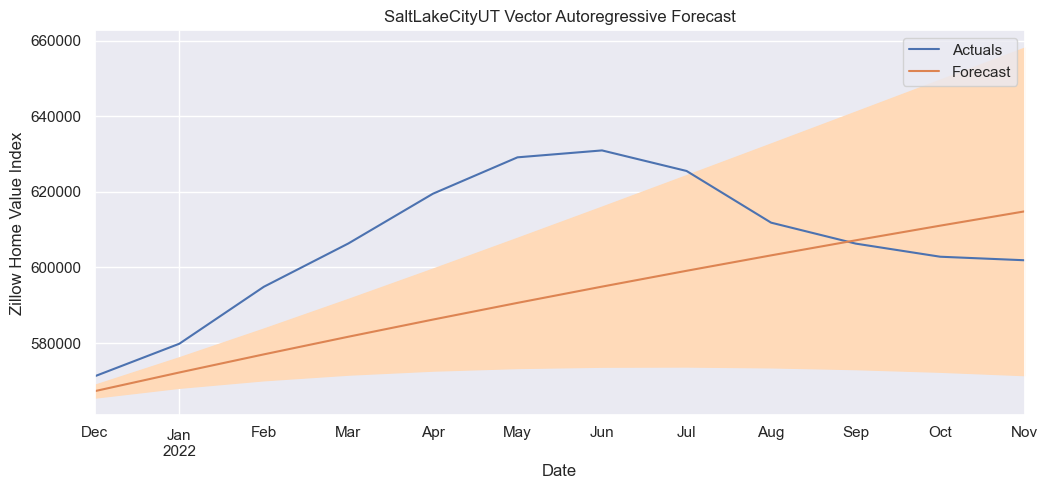

In [13]:
#Plot forecasts vs. actuals

df_actuals = market_df[-test_obs:]
df_actuals.iloc[:, 0].plot(figsize = (12, 5), legend = True, label = 'Actuals')
df_forecast.iloc[:,0].plot(legend = True, label = 'Forecast')
plt.title(location + " Vector Autoregressive Forecast")
plt.xlabel("Date")
plt.ylabel("Zillow Home Value Index")
plt.legend()

plt.fill_between(df_forecast.index, df_forecast_lower.iloc[:,0], df_forecast_upper.iloc[:,0], color='peachpuff')

plt.show()

In [14]:
#Use cross validation to evaluate the model
from sklearn.metrics import mean_absolute_percentage_error

def time_series_cv(data, raw_data, test_feature, starting_index, horizon, num_diffs, lags):
    
    final_obs = len(data) - horizon
    predictions = np.array([])
    actuals = np.array([])
    
    for t in range(starting_index, final_obs):
        df = data.iloc[0:t]
        
        model = VAR(df)
        
        features_prediction = model.fit(lags).forecast(df.values[-lags:,:], horizon)
 
        if num_diffs == 2:
            prev_difference = (raw_data.iloc[t+num_diffs,:] - raw_data.iloc[t+num_diffs-1,:]).values
            features_prediction = prev_difference + features_prediction.cumsum(axis=0)
        if num_diffs >= 1:
            prev_value = raw_data.iloc[t+num_diffs,:].values
            features_prediction = prev_value + features_prediction.cumsum(axis=0)
        predictions = np.append(predictions, features_prediction[-1, data.columns==market_specific_features[0]])
        
        actuals = np.append(actuals, raw_data.iloc[t+num_diffs+horizon][test_feature])

    MAPE = mean_absolute_percentage_error(actuals, predictions)
    
    print('MAPE:', MAPE)

In [15]:
time_series_cv(data=train_df, raw_data=market_df, test_feature=market_specific_features[0], 
               starting_index=100, horizon=forecast_horizon, num_diffs=n, lags=p)

MAPE: 0.006773447008214821


In [16]:
#Use VARMAX(p, 0) to forecast out of sample predictions. 

from statsmodels.tsa.statespace.varmax import VARMAX
oos_model = VARMAX(df_differenced, order = (p,0))
oos_result = oos_model.fit(maxiter = 100)
oos_forecast = oos_result.get_forecast(steps = forecast_horizon)
oos_summary = oos_forecast.summary_frame(alpha=0.05)

if n == 2:
    oos_summary = market_df.iloc[-1, 0] - market_df.iloc[-2, 0] + oos_summary.cumsum()
if n >= 1:
    oos_summary = market_df.iloc[-1, 0] + oos_summary.cumsum()

var_final = round(oos_summary.iloc[-1, 0], 2)
var_final_lower = round(oos_summary.iloc[-1, 2], 2)
var_final_upper = round(oos_summary.iloc[-1, 3], 2)